In [69]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import gala.dynamics as gd
import gala.potential as gp
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize_scalar
from matplotlib.patches import Ellipse

Helper Functions

In [70]:
def sample(dict, ics):
    n_samples = 100
    ra_samples = np.random.normal(dict['ra'], dict['e_ra'], n_samples)
    dec_samples = np.random.normal(dict['dec'], dict['e_dec'], n_samples)
    dist_samples = np.random.normal(dict['dist'], dict['e_dist'], n_samples)
    pmra_samples = np.random.normal(dict['pmra'], dict['e_pmra'], n_samples)
    pmdec_samples = np.random.normal(dict['pmdec'], dict['e_pmdec'], n_samples)
    rv_samples = np.random.normal(dict['rv'], dict['e_rv'], n_samples)

    ics_list = []
    ics_list.append(ics)
    for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
        sc = coord.SkyCoord(ra=ra * u.degree,
                    dec=dec * u.degree,
                    distance=dist * u.kpc,
                    pm_ra_cosdec=pmra * (u.mas / u.yr),
                    pm_dec=pmdec * (u.mas / u.yr),
                    radial_velocity=rv * (u.km / u.s),
                    frame="icrs")
        gc = sc.transform_to(coord.Galactocentric)
        ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
        ics_list.append(ics)
    
    return ics_list

def calculate_orbits(dict, ics, num_steps):
    ics_list = sample(dict, ics)

    orbits = []
    for ics in ics_list:
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
        orbits.append(orbit)

    return orbits

def plot_ellipse(x_vals, y_vals):
    pos = np.column_stack((x_vals, y_vals))
    mean = np.mean(pos, axis=0)
    cov = np.cov(pos, rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(x_vals, y_vals, s=3, color='red', alpha=0.5)

    # Confidence levels: 1σ (68%), 2σ (95%), 3σ (99.7%)
    for nsig in [1, 2, 3]:
        width, height = 2 * nsig * np.sqrt(eigvals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          edgecolor='blue', fc='None', lw=2, label=f"{nsig}σ")
        ax.add_patch(ellipse)

    ax.set_xlabel(f"X [kpc]")
    ax.set_ylabel(f"Y [kpc]")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_distance(num_steps, ics):
    orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
    final_z = orbit[-1].pos.xyz.to(u.kpc).value[2]
    return final_z

def plot_mw(dict, ics):
    ics_list = sample(dict, ics)

    points = []
    for ics in ics_list:
        result = minimize_scalar(
            calculate_distance,
            args=(ics),
            bounds=(0, 3000),  # search between 0 and 3000 steps (300 Myr)
            method='bounded'
        )
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=result.x)
        final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:2]
        points.append(final_pos)

    points = np.array(points)

    x = points[:, 0]
    y = points[:, 1]

    plot_ellipse(x, y)

First, define a gravitational potential.

In [71]:
pot = gp.MilkyWayPotential()

Crater II

In [72]:
dwarf_dict = {
    'ra': 177.310, #degree
    'e_ra': 0.03, #degree
    'dec': -18.413, #degree
    'e_dec': 0.03, #degree
    'dist': 117.5, #kpc
    'e_dist': 1.1, #kpc
    'pmra': -0.07, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -0.11, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': 87.5, #km/s
    'e_rv': 0.4, #km/s
    }
dwarf = coord.SkyCoord(
    ra=dwarf_dict['ra'] * u.degree,
    dec=dwarf_dict['dec'] * u.degree,
    distance=dwarf_dict['dist'] * u.kpc,
    pm_ra_cosdec=dwarf_dict['pmra'] * (u.mas / u.yr),
    pm_dec=dwarf_dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dwarf_dict['rv'] * (u.km / u.s),
    frame="icrs"
)
dwarf_GC = dwarf.transform_to(coord.Galactocentric)
dwarf_ics = gd.PhaseSpacePosition(pos=dwarf_GC.cartesian.xyz, vel=dwarf_GC.velocity.d_xyz)

Other Galaxies

In [73]:
other_galaxies = []

LeoI = {
    'ra': 152.117175, #degree
    'e_ra': 0.0001, #degree
    'dec': 12.3065, #degree
    'e_dec': 0.0001, #degree
    'dist': 254.0, #kpc
    'e_dist': 15.5, #kpc
    'pmra': -0.007, #mas/yr
    'e_pmra': 0.035, #mas/yr
    'pmdec': -0.119, #mas/yr
    'e_pmdec': 0.026, #mas/yr
    'rv': 282.9, #km/s
    'e_rv': 0.5, #km/s
    }
other_galaxies.append(LeoI)

Sextans = {
    'ra': 153.262584, #degree
    'e_ra': 0.0001, #degree
    'dec': -1.6147, #degree
    'e_dec': 0.0001, #degree
    'dist': 95.0, #kpc
    'e_dist': 3.0, #kpc
    'pmra': -0.41, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': 0.04, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': 224.3, #km/s
    'e_rv': 0.1, #km/s
    }
other_galaxies.append(Sextans)

UrsaMajorI = {
    'ra': 158.72, #degree
    'e_ra': 0.0001, #degree
    'dec': 51.92, #degree
    'e_dec': 0.0001, #degree
    'dist': 97.3, #kpc
    'e_dist': 5.8, #kpc
    'pmra': -0.39, #mas/yr
    'e_pmra': 0.03, #mas/yr
    'pmdec': -0.63, #mas/yr
    'e_pmdec': 0.03, #mas/yr
    'rv': -55.3, #km/s
    'e_rv': 1.4, #km/s
    }
other_galaxies.append(UrsaMajorI)

WillmanI = {
    'ra': 162.343, #degree
    'e_ra': 0.0001, #degree
    'dec': 51.051, #degree
    'e_dec': 0.0001, #degree
    'dist': 45.0, #kpc
    'e_dist': 10.0, #kpc
    'pmra': 0.21, #mas/yr
    'e_pmra': 0.06, #mas/yr
    'pmdec': -1.08, #mas/yr
    'e_pmdec': 0.09, #mas/yr
    'rv': -14.1, #km/s
    'e_rv': 1.0, #km/s
    }
other_galaxies.append(WillmanI)

LeoII = {
    'ra': 168, #degree
    'e_ra': 0.0001, #degree
    'dec': 22.15, #degree
    'e_dec': 0.0001, #degree
    'dist': 233.0, #kpc
    'e_dist': 14.0, #kpc
    'pmra': -0.14, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -0.12, #mas/yr
    'e_pmdec': 0.02, #mas/yr
    'rv': 78.3, #km/s
    'e_rv': 0.6, #km/s
    }
other_galaxies.append(LeoII)

LeoV = {
    'ra': 172.79, #degree
    'e_ra': 0.0001, #degree
    'dec': 2.22, #degree
    'e_dec': 0.0001, #degree
    'dist': 169.0, #kpc
    'e_dist': 4.0, #kpc
    'pmra': -0.06, #mas/yr
    'e_pmra': 0.09, #mas/yr
    'pmdec': -0.25, #mas/yr
    'e_pmdec': 0.085, #mas/yr
    'rv': 170.9, #km/s
    'e_rv': 2.0, #km/s
    }
other_galaxies.append(LeoV)

LeoIV = {
    'ra': 173.2375, #degree
    'e_ra': 0.0001, #degree
    'dec': -0.5333, #degree
    'e_dec': 0.0001, #degree
    'dist': 154.0, #kpc
    'e_dist': 5.0, #kpc
    'pmra': -0.08, #mas/yr
    'e_pmra': 0.09, #mas/yr
    'pmdec': -0.21, #mas/yr
    'e_pmdec': 0.08, #mas/yr
    'rv': 132.3, #km/s
    'e_rv': 1.4, #km/s
    }
other_galaxies.append(LeoIV)

HydraII = {
    'ra': 185.425, #degree
    'e_ra': 0.01, #degree
    'dec': -31.9853, #degree
    'e_dec': 0.01, #degree
    'dist': 151.0, #kpc
    'e_dist': 7.5, #kpc
    'pmra': -0.34, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': -0.09, #mas/yr
    'e_pmdec': 0.085, #mas/yr
    'rv': 303.1, #km/s
    'e_rv': 1.4, #km/s
    }
other_galaxies.append(HydraII)

ComaBerenices = {
    'ra': 186.7458, #degree
    'e_ra': 10.0, #degree
    'dec': 23.919, #degree
    'e_dec': 10.0, #degree
    'dist': 42.0, #kpc
    'e_dist': 1.55, #kpc
    'pmra': 0.41, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -1.71, #mas/yr
    'e_pmdec': 0.02, #mas/yr
    'rv': 98.1, #km/s
    'e_rv': 0.9, #km/s
    }
other_galaxies.append(ComaBerenices)

CanesVenaticiII = {
    'ra': 194.2917, #degree
    'e_ra': 0.01, #degree
    'dec': 34.3209, #degree
    'e_dec': 0.01, #degree
    'dist': 160.0, #kpc
    'e_dist': 4.0, #kpc
    'pmra': -0.15, #mas/yr
    'e_pmra': 0.07, #mas/yr
    'pmdec': -0.27, #mas/yr
    'e_pmdec': 0.06, #mas/yr
    'rv': -128.9, #km/s
    'e_rv': 1.2, #km/s
    }
other_galaxies.append(CanesVenaticiII)

CanesVenaticiI = {
    'ra': 202.0146, #degree
    'e_ra': 0.01, #degree
    'dec': 33.5558, #degree
    'e_dec': 0.01, #degree
    'dist': 211.0, #kpc
    'e_dist': 6.0, #kpc
    'pmra': -0.11, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -0.12, #mas/yr
    'e_pmdec': 0.02, #mas/yr
    'rv': 30.9, #km/s
    'e_rv': 0.6, #km/s
    }
other_galaxies.append(CanesVenaticiI)

BootesII = {
    'ra': 209.5, #degree
    'e_ra': 0.01, #degree
    'dec': 12.85, #degree
    'e_dec': 0.01, #degree
    'dist': 42.0, #kpc
    'e_dist': 1.0, #kpc
    'pmra': -2.33, #mas/yr
    'e_pmra': 0.085, #mas/yr
    'pmdec': -0.41, #mas/yr
    'e_pmdec': 0.06, #mas/yr
    'rv': -117.0, #km/s
    'e_rv': 5.2, #km/s
    }
other_galaxies.append(BootesII)

BootesI = {
    'ra': 210.025, #degree
    'e_ra': 0.01, #degree
    'dec': 14.5, #degree
    'e_dec': 0.01, #degree
    'dist': 66.0, #kpc
    'e_dist': 2.0, #kpc
    'pmra': -0.39, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': -1.06, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': 101.8, #km/s
    'e_rv': 0.7, #km/s
    }
other_galaxies.append(BootesI)

UrsaMinor = {
    'ra': 227.2854, #degree
    'e_ra': 0.01, #degree
    'dec': 67.2225, #degree
    'e_dec': 0.01, #degree
    'dist': 76.0, #kpc
    'e_dist': 4.0, #kpc
    'pmra': -0.124, #mas/yr
    'e_pmra': 0.004, #mas/yr
    'pmdec': 0.078, #mas/yr
    'e_pmdec': 0.004, #mas/yr
    'rv': -247.2, #km/s
    'e_rv': 0.8, #km/s
    }
other_galaxies.append(UrsaMinor)

DracoII = {
    'ra': 238.198, #degree
    'e_ra': 0.01, #degree
    'dec': 64.5653, #degree
    'e_dec': 0.01, #degree
    'dist': 21.5, #kpc
    'e_dist': 0.4, #kpc
    'pmra': 1.08, #mas/yr
    'e_pmra': 0.07, #mas/yr
    'pmdec': 0.91, #mas/yr
    'e_pmdec': 0.08, #mas/yr
    'rv': -342.5, #km/s
    'e_rv': 1.15, #km/s
    }
other_galaxies.append(DracoII)

Hercules = {
    'ra': 247.7583 , #degree
    'e_ra': 0.01, #degree
    'dec': 12.7916, #degree
    'e_dec': 0.01, #degree
    'dist': 132.0, #kpc
    'e_dist': 6.0, #kpc
    'pmra': -0.03, #mas/yr
    'e_pmra': 0.04, #mas/yr
    'pmdec': -0.36, #mas/yr
    'e_pmdec': 0.03, #mas/yr
    'rv': 45.0, #km/s
    'e_rv': 1.1, #km/s
    }
other_galaxies.append(Hercules)

Draco = {
    'ra': 260.05162 , #degree
    'e_ra': 0.01, #degree
    'dec': 57.91536, #degree
    'e_dec': 0.01, #degree
    'dist': 82.0, #kpc
    'e_dist': 6.0, #kpc
    'pmra': 0.042, #mas/yr
    'e_pmra': 0.005, #mas/yr
    'pmdec': -0.19, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': -290.7, #km/s
    'e_rv': 0.75, #km/s
    }
other_galaxies.append(Draco)

Sculptor = {
    'ra': 15.0387 , #degree
    'e_ra': 0.01, #degree
    'dec': -33.7092, #degree
    'e_dec': 0.01, #degree
    'dist': 86.0, #kpc
    'e_dist': 5.0, #kpc
    'pmra': 0.099, #mas/yr
    'e_pmra': 0.002, #mas/yr
    'pmdec': -0.160, #mas/yr
    'e_pmdec': 0.002, #mas/yr
    'rv': 111.4, #km/s
    'e_rv': 0.1, #km/s
    }
other_galaxies.append(Sculptor)

TriangulumII = {
    'ra': 33.323 , #degree
    'e_ra': 0.01, #degree
    'dec': 36.178, #degree
    'e_dec': 0.01, #degree
    'dist': 28.4, #kpc
    'e_dist': 1.6, #kpc
    'pmra': 0.56, #mas/yr
    'e_pmra': 0.05, #mas/yr
    'pmdec': 0.07, #mas/yr
    'e_pmdec': 0.06, #mas/yr
    'rv': -381.7, #km/s
    'e_rv': 1.1, #km/s
    }
other_galaxies.append(TriangulumII)

Segue2 = {
    'ra': 34.817, #degree
    'e_ra': 0.01, #degree
    'dec': 20.175, #degree
    'e_dec': 0.01, #degree
    'dist': 37.0, #kpc
    'e_dist': 3.0, #kpc
    'pmra': 1.47, #mas/yr
    'e_pmra': 0.04, #mas/yr
    'pmdec': -0.31, #mas/yr
    'e_pmdec': 0.04, #mas/yr
    'rv': -40.2, #km/s
    'e_rv': 0.9, #km/s
    }
other_galaxies.append(Segue2)

HydrusI = {
    'ra': 37.39, #degree
    'e_ra': 0.01, #degree
    'dec': -79.30, #degree
    'e_dec': 0.01, #degree
    'dist': 27.6, #kpc
    'e_dist': 0.5, #kpc
    'pmra': 3.79, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': -1.5, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': 80.4, #km/s
    'e_rv': 0.6, #km/s
    }
other_galaxies.append(HydrusI)

Fornax = {
    'ra': 39.997, #degree
    'e_ra': 0.01, #degree
    'dec': -34.449, #degree
    'e_dec': 0.01, #degree
    'dist': 139.0, #kpc
    'e_dist': 3.0, #kpc
    'pmra': 0.382, #mas/yr
    'e_pmra': 0.001, #mas/yr
    'pmdec': -0.359, #mas/yr
    'e_pmdec': 0.002, #mas/yr
    'rv': 55.2, #km/s
    'e_rv': 0.1, #km/s
    }
other_galaxies.append(Fornax)

HorologiumI = {
    'ra': 49.75, #degree
    'e_ra': 0.01, #degree
    'dec': -50.03, #degree
    'e_dec': 0.01, #degree
    'dist': 87.0, #kpc
    'e_dist': 12.0, #kpc
    'pmra': 0.82, #mas/yr
    'e_pmra': 0.03, #mas/yr
    'pmdec': -0.61, #mas/yr
    'e_pmdec': 0.03, #mas/yr
    'rv': 112.8, #km/s
    'e_rv': 2.55, #km/s
    }
other_galaxies.append(HorologiumI)

ReticulumII = {
    'ra': 53.9254, #degree
    'e_ra': 0.01, #degree
    'dec': -54.0492, #degree
    'e_dec': 0.01, #degree
    'dist': 31.6, #kpc
    'e_dist': 1.45, #kpc
    'pmra': 2.39, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': -1.36, #mas/yr
    'e_pmdec': 0.02, #mas/yr
    'rv': 62.8, #km/s
    'e_rv': 0.5, #km/s
    }
other_galaxies.append(ReticulumII)

EridanusII = {
    'ra': 56.0838, #degree
    'e_ra': 0.01, #degree
    'dec': -43.5338, #degree
    'e_dec': 0.01, #degree
    'dist': 366.0, #kpc
    'e_dist': 17.0, #kpc
    'pmra': 0.12, #mas/yr
    'e_pmra': 0.05, #mas/yr
    'pmdec': -0.06, #mas/yr
    'e_pmdec': 0.05, #mas/yr
    'rv': 75.6, #km/s
    'e_rv': 1.3, #km/s
    }
other_galaxies.append(EridanusII)

Carina = {
    'ra': 100.403, #degree
    'e_ra': 0.01, #degree
    'dec': -50.966, #degree
    'e_dec': 0.01, #degree
    'dist': 106.0, #kpc
    'e_dist': 5.0, #kpc
    'pmra': 0.53, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': 0.12, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': 222.9, #km/s
    'e_rv': 0.1, #km/s
    }
other_galaxies.append(Carina)

CarinaII = {
    'ra': 114.167, #degree
    'e_ra': 0.01, #degree
    'dec': -58.05, #degree
    'e_dec': 0.01, #degree
    'dist': 36.2, #kpc
    'e_dist': 0.6, #kpc
    'pmra': 1.88, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': 0.13, #mas/yr
    'e_pmdec': 0.02, #mas/yr
    'rv': 477.2, #km/s
    'e_rv': 1.2, #km/s
    }
other_galaxies.append(CarinaII)

CarinaIII = {
    'ra': 100.403, #degree
    'e_ra': 0.01, #degree
    'dec': -50.9661, #degree
    'e_dec': 0.01, #degree
    'dist': 27.8, #kpc
    'e_dist': 0.6, #kpc
    'pmra': 3.12, #mas/yr
    'e_pmra': 0.05, #mas/yr
    'pmdec': 1.54, #mas/yr
    'e_pmdec': 0.065, #mas/yr
    'rv': 284.6, #km/s
    'e_rv': 3.25, #km/s
    }
other_galaxies.append(CarinaIII)

UrsaMajorII = {
    'ra': 132.875, #degree
    'e_ra': 0.01, #degree
    'dec': 63.13, #degree
    'e_dec': 0.01, #degree
    'dist': 34.7, #kpc
    'e_dist': 1.95, #kpc
    'pmra': 1.72, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -1.89, #mas/yr
    'e_pmdec': 0.03, #mas/yr
    'rv': -116.5, #km/s
    'e_rv': 1.9, #km/s
    }
other_galaxies.append(UrsaMajorII)

LeoT = {
    'ra': 143.7225, #degree
    'e_ra': 0.01, #degree
    'dec': 17.05138, #degree
    'e_dec': 0.01, #degree
    'dist': 409.0, #kpc
    'e_dist': 28.0, #kpc
    'pmra': -0.01, #mas/yr
    'e_pmra': 0.05, #mas/yr
    'pmdec': -0.11, #mas/yr
    'e_pmdec': 0.05, #mas/yr
    'rv': 38.1, #km/s
    'e_rv': 2.0, #km/s
    }
other_galaxies.append(LeoT)

Segue1 = {
    'ra': 151.76333, #degree
    'e_ra': 0.01, #degree
    'dec': 16.07361, #degree
    'e_dec': 0.01, #degree
    'dist': 23.0, #kpc
    'e_dist': 2.0, #kpc
    'pmra': -2.21, #mas/yr
    'e_pmra': 0.06, #mas/yr
    'pmdec': -3.34, #mas/yr
    'e_pmdec': 0.05, #mas/yr
    'rv': 208.5, #km/s
    'e_rv': 0.9, #km/s
    }
other_galaxies.append(Segue1)

PegasusIII = {
    'ra': 336.1075833, #degree
    'e_ra': 0.01, #degree
    'dec': 5.41500277, #degree
    'e_dec': 0.01, #degree
    'dist': 205.0, #kpc
    'e_dist': 20.0, #kpc
    'pmra': 0.06, #mas/yr
    'e_pmra': 0.1, #mas/yr
    'pmdec': -0.2, #mas/yr
    'e_pmdec': 0.1, #mas/yr
    'rv': -222.9, #km/s
    'e_rv': 2.6, #km/s
    }
other_galaxies.append(PegasusIII)

AquariusII = {
    'ra': 338.4813, #degree
    'e_ra': 0.01, #degree
    'dec': -9.3274, #degree
    'e_dec': 0.01, #degree
    'dist': 107.9, #kpc
    'e_dist': 3.3, #kpc
    'pmra': -0.17, #mas/yr
    'e_pmra': 0.1, #mas/yr
    'pmdec': -0.43, #mas/yr
    'e_pmdec': 0.08, #mas/yr
    'rv': -71.1, #km/s
    'e_rv': 2.5, #km/s
    }
other_galaxies.append(AquariusII)

HVS 14

In [74]:
dict14 = {
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }
hvs14 = coord.SkyCoord(
    ra=dict14['ra'] * u.degree,
    dec=dict14['dec'] * u.degree,
    distance=dict14['dist'] * u.kpc,
    pm_ra_cosdec=dict14['pmra'] * (u.mas / u.yr),
    pm_dec=dict14['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict14['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs14_GC = hvs14.transform_to(coord.Galactocentric)
hvs14_ics = gd.PhaseSpacePosition(pos=hvs14_GC.cartesian.xyz, vel=hvs14_GC.velocity.d_xyz)

Milky Way Plot (z=0)

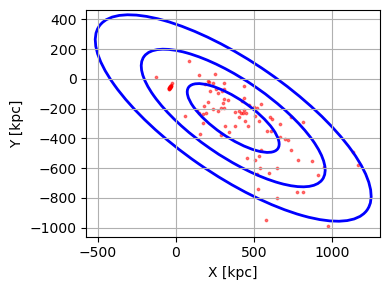

In [75]:
plot_mw(dict14, hvs14_ics)

Galaxy Plot

/var/folders/6r/r2sgx64n6zn9w5rn7t027xx00000gn/T/ipykernel_336/2288212491.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


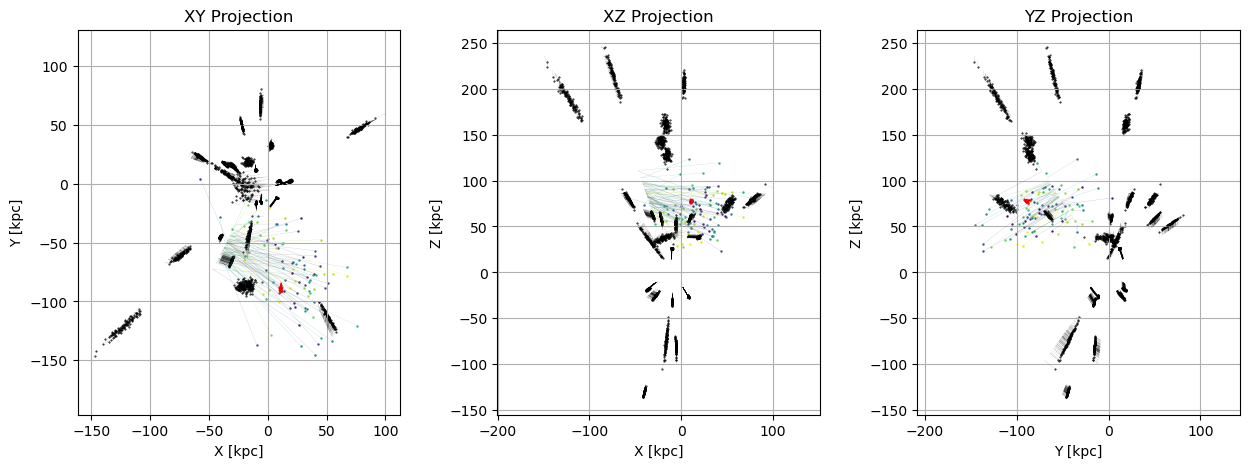

In [76]:
min14 = 366.5427377870987

hvs14_orbits = calculate_orbits(dict14, hvs14_ics, min14)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min14)

galaxy_orbits = []
for galaxy in other_galaxies:
    SkyCoord = coord.SkyCoord(
        ra=galaxy['ra'] * u.degree,
        dec=galaxy['dec'] * u.degree,
        distance=galaxy['dist'] * u.kpc,
        pm_ra_cosdec=galaxy['pmra'] * (u.mas / u.yr),
        pm_dec=galaxy['pmdec'] * (u.mas / u.yr),
        radial_velocity=galaxy['rv'] * (u.km / u.s),
        frame="icrs"
    )
    GC = SkyCoord.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=GC.cartesian.xyz, vel=GC.velocity.d_xyz)
    orbits = calculate_orbits(galaxy, ics, min14)
    galaxy_orbits.append(orbits)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(hvs14_orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='red', marker='o', s=0.2)
for galaxy_orbit in galaxy_orbits:
    for orbit in galaxy_orbit:
        pos = orbit.pos.xyz.value
        plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
        plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(hvs14_orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='red', marker='o', s=0.2)
for galaxy_orbit in galaxy_orbits:
    for orbit in galaxy_orbit:
        pos = orbit.pos.xyz.value
        plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
        plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(hvs14_orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='red', marker='o', s=0.2)
for galaxy_orbit in galaxy_orbits:
    for orbit in galaxy_orbit:
        pos = orbit.pos.xyz.value
        plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
        plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('galaxies+HVS14.png')
plt.show()